In [4]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-09-10 18:21:42.218328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
df = pd.read_csv('../datasets/heart.csv')
df.sample(5)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


In [7]:
features = df.drop('target', axis=1)
target = df[['target']]

In [9]:
numeric_features = features[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].copy()
categorical_features = features[['sex', 'fbs', 'exang', 'cp', 'ca', 'slope', 'thal', 'restecg']].copy()
                                 
standardScaler = StandardScaler() # convert to Z score
numeric_features = pd.DataFrame(standardScaler.fit_transform(numeric_features),
                                columns = numeric_features.columns,
                                index = numeric_features.index)

In [10]:
processed_features = pd.concat([numeric_features, categorical_features], axis=1,
                               sort = False)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(processed_features, target, 
                                                    test_size=0.2, 
                                                    random_state=1)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size = 0.15, random_state=10)

In [18]:
def build_model():
    inputs = tf.keras.Input(shape=(x_train.shape[1],)) # input layer shape is # of features
    dense_layer1 = layers.Dense(12, activation = 'relu')
    x = dense_layer1(inputs)

    dropout_layer = layers.Dropout(0.3) 
    #mitigate effects of overfitting. Drop off 30% of neurons in first dense layer, forcing other neurons to learn
    x = dropout_layer(x)
    
    dense_layer2 = layers.Dense(8, activation = 'relu')
    x = dense_layer2(x)

    predictions_layer = layers.Dense(1, activation = 'sigmoid') #output is a probability score
    predictions = predictions_layer(x)

    model = tf.keras.Model(inputs=inputs, outputs = predictions)
    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=tf.keras.losses.BinaryCrossentropy(), #loss function for binary classifier
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(0.5),
                           tf.keras.metrics.Recall(0.5),])
    return model


In [19]:
model = build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_2 (Dense)             (None, 12)                168       
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 104       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 281 (1.10 KB)
Trainable params: 281 (1.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
dataset_train = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values))
dataset_train = dataset_train.batch(16)
dataset_train.shuffle(128)
# convert training data tensors into dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 13), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [24]:
num_epochs = 100

In [26]:
dataset_val = tf.data.Dataset.from_tensor_slices((x_val.values, y_val.values))
dataset_val = dataset_val.batch(16)

In [27]:
model = build_model()
training_history = model.fit(dataset_train, epochs = num_epochs, validation_data = dataset_val)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_5 (Dense)             (None, 12)                168       
                                                                 
 dropout_2 (Dropout)         (None, 12)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 104       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 281 (1.10 KB)
Trainable params: 281 (1.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
37/37 [==========

In [28]:
training_history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

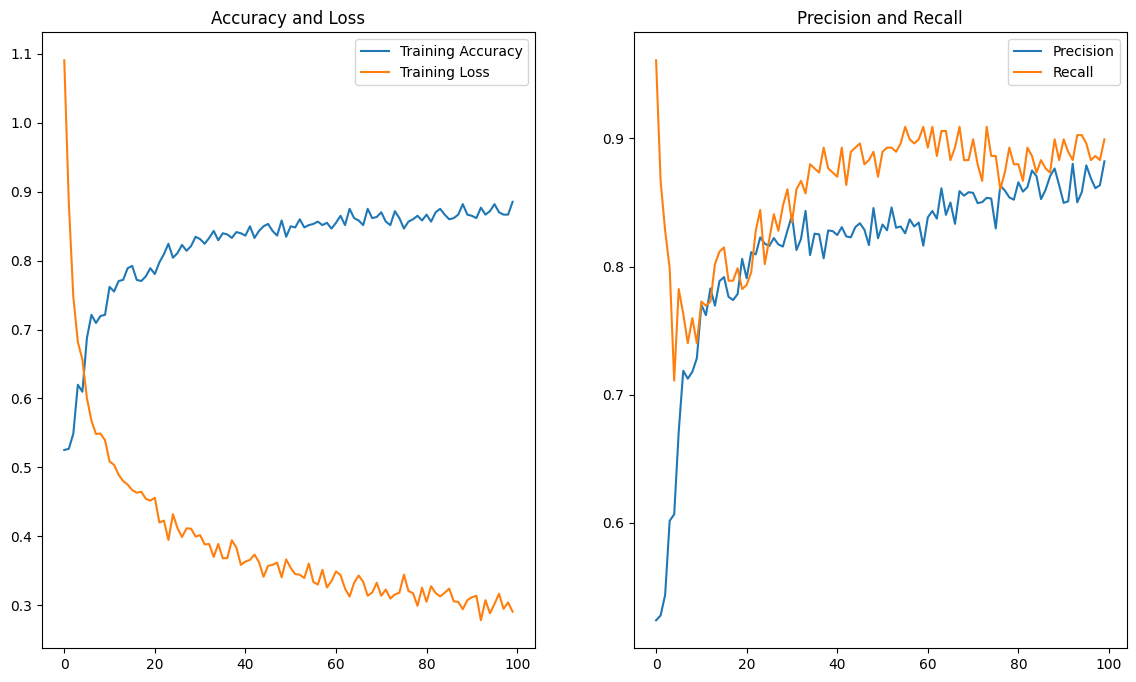

In [30]:
train_acc = training_history.history['accuracy']
train_loss = training_history.history['loss']
precision = training_history.history['precision_1']
recall = training_history.history['recall_1']

epochs_range = range(num_epochs)

plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label = 'Training Accuracy')
plt.plot(epochs_range, train_loss, label = 'Training Loss')
plt.title('Accuracy and Loss')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs_range, precision, label = 'Precision')
plt.plot(epochs_range, recall, label = 'Recall')
plt.title('Precision and Recall')
plt.legend()

In [32]:
score = model.evaluate(x_test, y_test)
score_df = pd.Series(score, index=model.metrics_names)
score_df

7/7 [==============================] - 0s 3ms/step - loss: 0.2930 - accuracy: 0.8585 - precision_1: 0.8018 - recall_1: 0.9271


loss           0.292959
accuracy       0.858537
precision_1    0.801802
recall_1       0.927083
dtype: float64

In [34]:
y_pred = model.predict(x_test)
y_pred[:10] # series of probability scores that patient has heart disease

7/7 [==============================] - 0s 2ms/step


array([[0.01795732],
       [0.94220257],
       [0.9772265 ],
       [0.689361  ],
       [0.00639217],
       [0.82323843],
       [0.759781  ],
       [0.9245505 ],
       [0.75109124],
       [0.75489813]], dtype=float32)

In [36]:
# apply threshold to probability scors to get actual predicitons
y_pred = np.where(y_pred>=0.5, 1, y_pred)
y_pred = np.where(y_pred<0.5, 0, y_pred)
y_pred[:10]

array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [38]:
pred_results = pd.DataFrame({'y_test': y_test.values.flatten(),
                           'y_pred': y_pred.flatten().astype('int32') }, index = range(len(y_pred)))

In [39]:
pd.crosstab(pred_results.y_pred, pred_results.y_test) # see what was classified accurately

y_test,0,1
y_pred,,
0,87,7
1,22,89
